# Calculate heatmaps of ImagNet

In [1]:
'''some setting for my weird GPU problem'''
####################################################################
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print('############## GPU PREPARATION DONE ##############')
####################################################################

############## GPU PREPARATION DONE ##############


In [2]:
'''import vgg model with imagenet weights'''
import keras
import keras.backend as K
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')


Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions, preprocess_input
import numpy as np

'''load targent image, resize and show'''
image_path = r'./image.jpeg'
img = image.load_img(path=image_path, target_size=(224,224))
type(img)

PIL.Image.Image

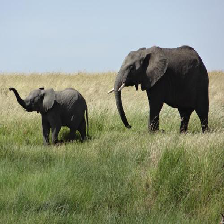

In [4]:
img

In [5]:
'''conver Image object to array'''
x = image.img_to_array(img)

'''add batch dim'''
x = np.expand_dims(x, axis=0)

'''normalize color channel'''
x = preprocess_input(x)

In [6]:
'''make a prediction and get the top 3 scored classes'''
preds = model.predict(x)
print('predicted: ', decode_predictions(preds, top=3)[0])

predicted:  [('n02504458', 'African_elephant', 0.6394231), ('n01871265', 'tusker', 0.30717972), ('n02504013', 'Indian_elephant', 0.030970044)]


In [7]:
'''get the top id'''
id = np.argmax(preds[0])
id

386

In [8]:
'''calc output gradient wrt feature map'''
output = model.output[:,id]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(loss=output, variables=last_conv_layer.output)[0]
grads

<tf.Tensor 'gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>

In [9]:
'''get weightf or each channel'''
pooled_grads = K.mean(grads, axis=(0,1,2))
pooled_grads

<tf.Tensor 'Mean:0' shape=(512,) dtype=float32>

In [10]:
'''construct heatmap'''
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_values, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_values[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap.shape

(14, 14)

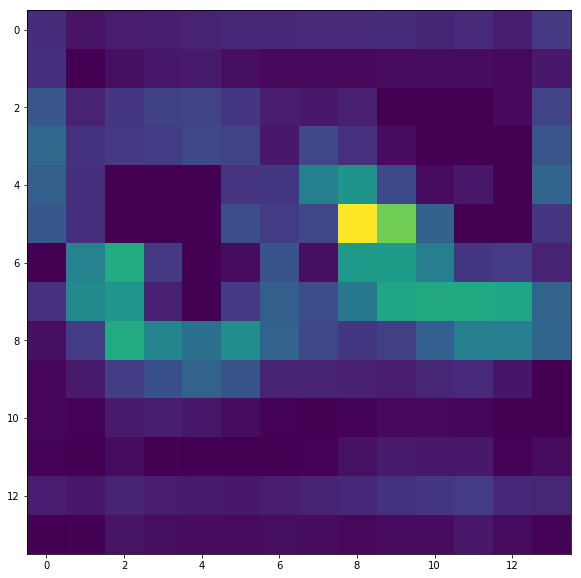

In [11]:
'''normalize and show'''
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
ax.imshow(heatmap)
plt.show()

In [12]:
'''resize heatmap'''
import cv2
img = cv2.imread(image_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap.shape

(375, 500)

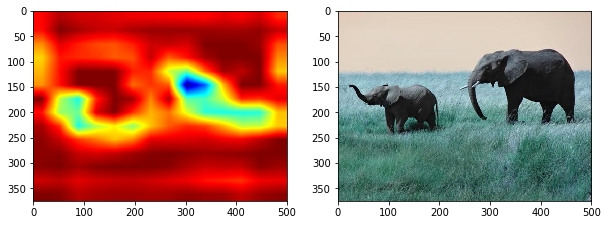

In [13]:
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(heatmap)
ax[1].imshow(img)
plt.show()

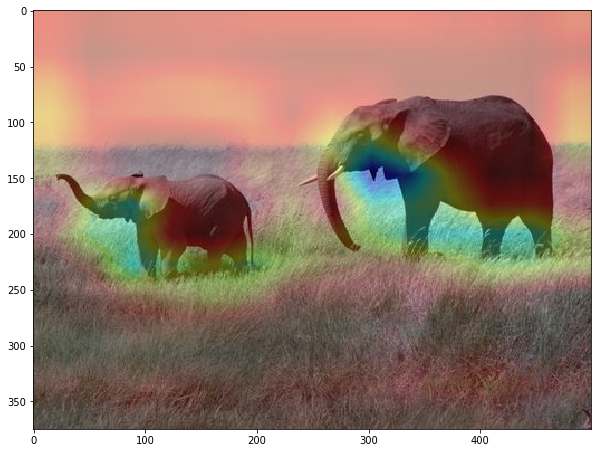

In [14]:
alpha = 0.3
superimposed_img = np.uint8(heatmap * alpha + (1-alpha)* img)

fig, ax = plt.subplots(1,figsize=(10,10))
ax.imshow(superimposed_img)
plt.show()